# time series forecasting

In [4]:
!pip install statsforecast utilsforecast

## dependencies

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *

from statsforecast import StatsForecast
from statsforecast.models import Naive, HistoricAverage, WindowAverage, SeasonalNaive, AutoARIMA

import warnings
warnings.filterwarnings("ignore")

## dataset

In [6]:
data = pd.read_csv("/content/daily_sales_french_bakery.csv", parse_dates=["ds"])
data.head(10)

,unique_id,ds,y,unit_price
0,12 MACARON,2022-07-13,10.0,10.0
1,12 MACARON,2022-07-14,0.0,10.0
2,12 MACARON,2022-07-15,0.0,10.0
3,12 MACARON,2022-07-16,10.0,10.0
4,12 MACARON,2022-07-17,30.0,10.0
5,12 MACARON,2022-07-18,0.0,10.0
6,12 MACARON,2022-07-19,10.0,10.0
7,12 MACARON,2022-07-20,0.0,10.0
8,12 MACARON,2022-07-21,10.0,10.0
9,12 MACARON,2022-07-22,0.0,10.0


In [7]:
data.shape

(57046, 4)

In [8]:
data["unique_id"].value_counts()

,count
unique_id,
BAGUETTE,637
BOULE 200G,637
BANETTE,637
BANETTINE,637
BRIOCHE,637
...,...
PLAT 6.50E,1
SACHET DE VIENNOISERIE,1
TARTELETTE COCKTAIL,1


In [9]:
data = data.groupby("unique_id").filter(lambda x: len(x) >= 28)
data = data.drop("unit_price", axis=1)
data.head(10)

,unique_id,ds,y
0,12 MACARON,2022-07-13,10.0
1,12 MACARON,2022-07-14,0.0
2,12 MACARON,2022-07-15,0.0
3,12 MACARON,2022-07-16,10.0
4,12 MACARON,2022-07-17,30.0
5,12 MACARON,2022-07-18,0.0
6,12 MACARON,2022-07-19,10.0
7,12 MACARON,2022-07-20,0.0
8,12 MACARON,2022-07-21,10.0
9,12 MACARON,2022-07-22,0.0


In [10]:
data.shape

(56904, 3)

In [11]:
data["unique_id"].value_counts()

,count
unique_id,
BAGUETTE,637
BOULE 400G,637
BANETTE,637
BOULE 200G,637
BANETTINE,637
...,...
RELIGIEUSE,71
SABLE F P,68
DELICETROPICAL,63


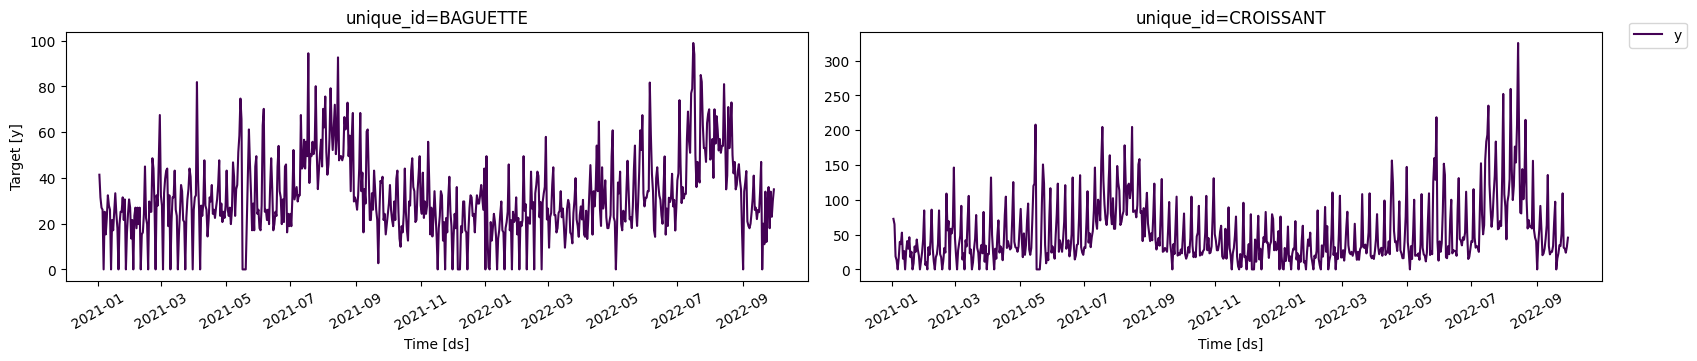

In [12]:
plot_series(
    df = data,
    ids = ["BAGUETTE", "CROISSANT"],
    palette = "viridis"
)

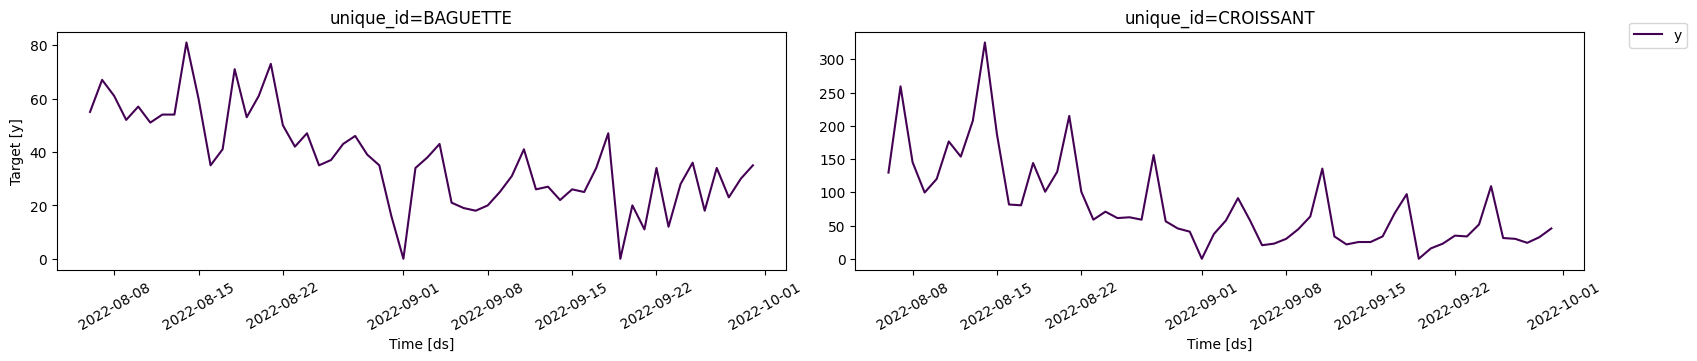

In [13]:
plot_series(
    df = data,
    ids = ["BAGUETTE", "CROISSANT"],
    max_insample_length = 56,
    palette = "viridis"
)

## base models

In [14]:
horizon = 7

models = [
    Naive(),
    HistoricAverage(),
    WindowAverage(window_size=7),
    SeasonalNaive(season_length=7)
]

sf = StatsForecast(
    models = models,
    freq = "D"
)
sf.fit(df = data)
preds = sf.predict(h=horizon)

In [15]:
preds.head()

,unique_id,ds,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,2022-09-29,10.0,8.974359,2.857143,0.0
1,12 MACARON,2022-09-30,10.0,8.974359,2.857143,0.0
2,12 MACARON,2022-10-01,10.0,8.974359,2.857143,10.0
3,12 MACARON,2022-10-02,10.0,8.974359,2.857143,0.0
4,12 MACARON,2022-10-03,10.0,8.974359,2.857143,0.0


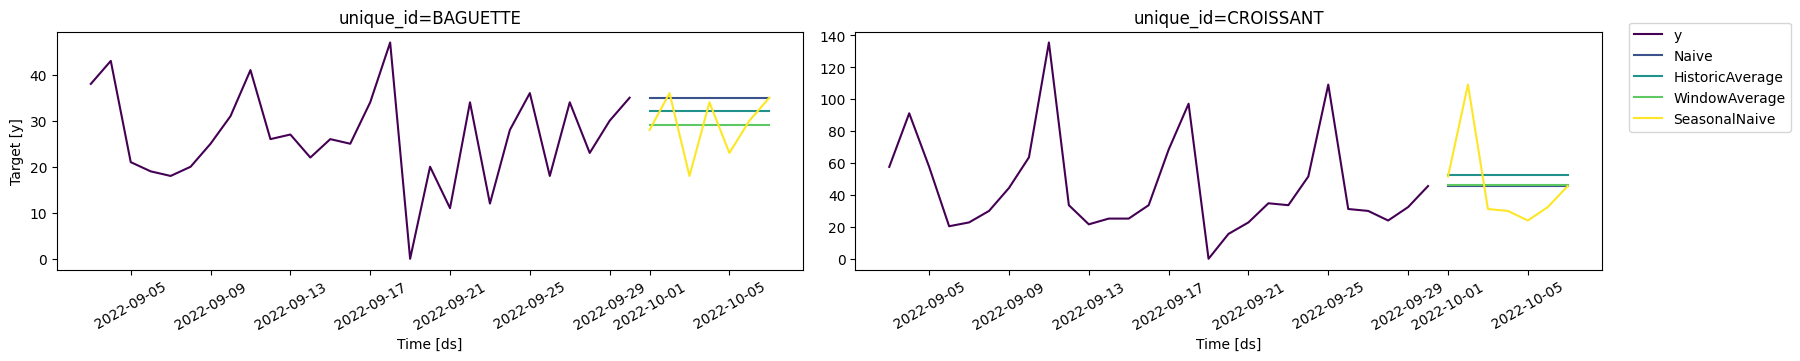

In [16]:
plot_series(
    df = data,
    forecasts_df = preds,
    ids = ["BAGUETTE", "CROISSANT"],
    max_insample_length = 28,
    palette = "viridis"
)

In [17]:
test = data.groupby("unique_id").tail(7)
train = data.drop(test.index).reset_index(drop=True)

In [18]:
sf.fit(df=train)
preds = sf.predict(h=horizon)
eval_df = pd.merge(
    test,
    preds,
    "left",
    ["ds", "unique_id"]
)

In [19]:
evaluation = evaluate(
    eval_df,
    metrics = [mae]
)
evaluation.head()

,unique_id,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,12 MACARON,mae,2.857143,6.961771,3.469388,4.285714
1,BAGUETTE,mae,17.142857,5.455193,7.877551,12.571429
2,BAGUETTE APERO,mae,0.000000,0.537572,0.642857,0.642857
3,BAGUETTE GRAINE,mae,9.800000,4.612271,2.942857,0.200000
4,BANETTE,mae,1.314286,5.421984,6.008163,7.885714


In [20]:
evaluation = evaluation.drop("unique_id", axis=1).groupby("metric").mean().reset_index()
evaluation

,metric,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,6.107556,5.228439,5.011663,4.613636


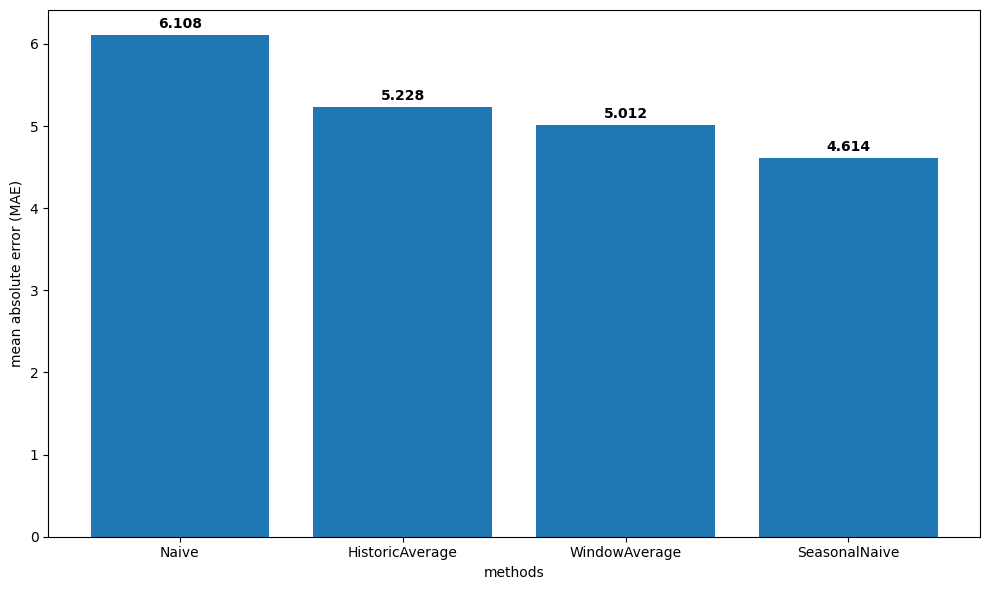

In [21]:
methods = evaluation.columns[1:].tolist()
values = evaluation.iloc[0, 1:].tolist()

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, values)

for bar, value in zip(bars, values):
  plt.text(
      bar.get_x() + bar.get_width()/2,
      bar.get_height() + 0.05,
      f"{value:.3f}",
      ha = "center",
      va = "bottom",
      fontweight = "bold"
  )

plt.xlabel("methods")
plt.ylabel("mean absolute error (MAE)")
plt.tight_layout()
plt.show()

## AutoARIMA

In [22]:
unique_ids = ["BAGUETTE", "CROISSANT"]

small_train = train[train["unique_id"].isin(unique_ids)]
small_test = test[test["unique_id"].isin(unique_ids)]

models = [
    AutoARIMA(seasonal=False, alias="ARIMA"),
    AutoARIMA(season_length=7, alias="SARIMA")
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=small_train)
arima_preds = sf.predict(h=horizon)

arima_eval_df = pd.merge(
    arima_preds,
    eval_df,
    "inner",
    ["ds", "unique_id"]
)

arima_eval = evaluate(
    arima_eval_df,
    metrics = [mae]
)
arima_eval

,unique_id,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,BAGUETTE,mae,9.353153,7.449083,17.142857,5.455193,7.877551,12.571429
1,CROISSANT,mae,14.565395,10.359143,17.485714,22.618934,18.244898,12.857143


In [23]:
arima_eval = arima_eval.drop("unique_id", axis=1).groupby("metric").mean().reset_index()
arima_eval

,metric,ARIMA,SARIMA,Naive,HistoricAverage,WindowAverage,SeasonalNaive
0,mae,11.959274,8.904113,17.314286,14.037063,13.061224,12.714286


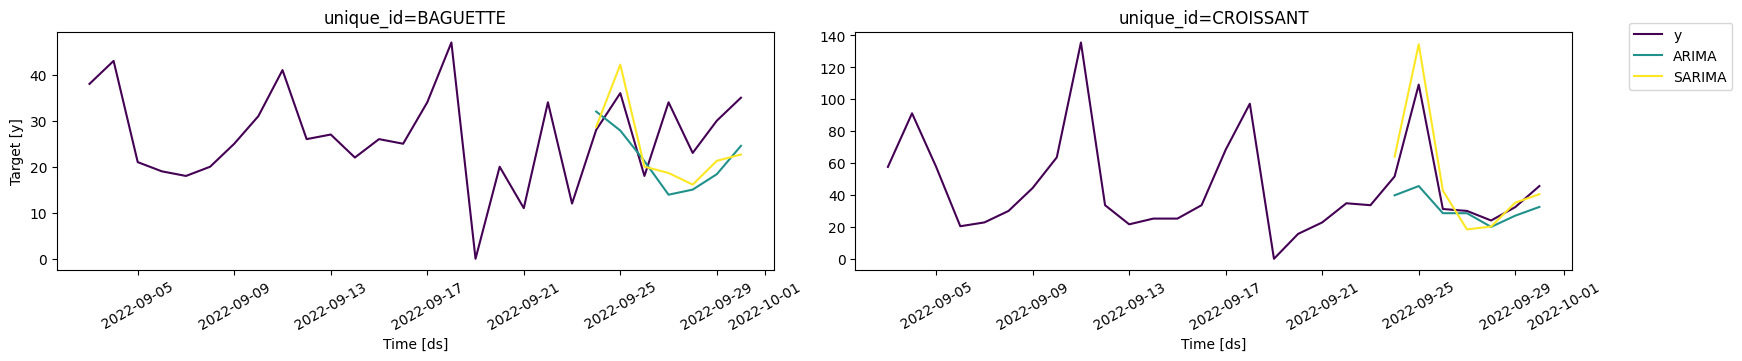

In [24]:
plot_series(
    df = data,
    forecasts_df = arima_preds,
    ids = ["BAGUETTE", "CROISSANT"],
    max_insample_length = 28,
    palette = "viridis"
)

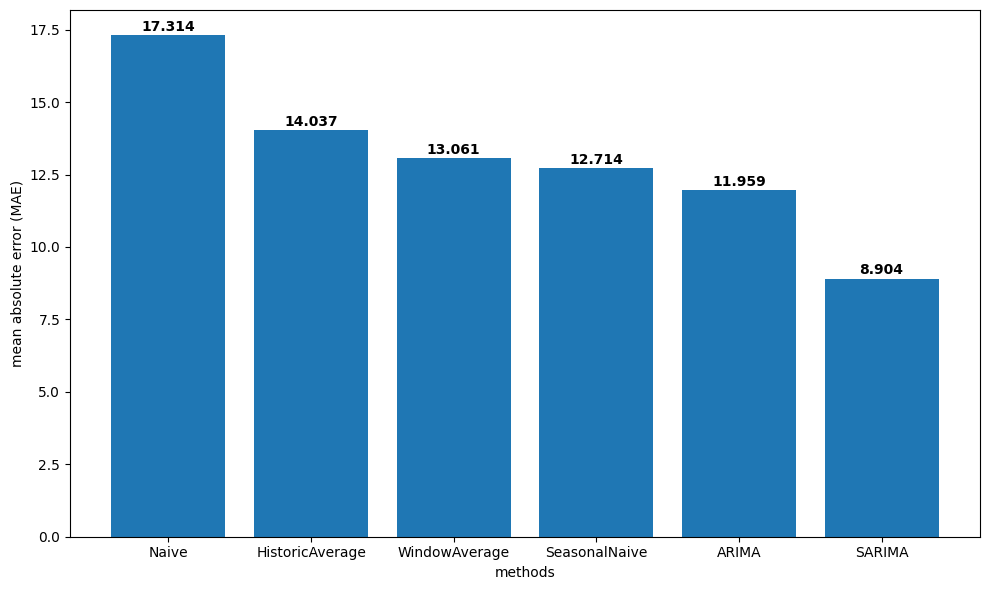

In [25]:
methods = arima_eval.columns[1:].tolist()
values = arima_eval.iloc[0, 1:].tolist()

sorted_data = sorted(
    zip(methods, values),
    key = lambda x: x[1],
    reverse = True
)
methods_sorted, values_sorted = zip(*sorted_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(methods_sorted, values_sorted)

for bar, value in zip(bars, values_sorted):
  plt.text(
      bar.get_x() + bar.get_width()/2,
      bar.get_height() + 0.05,
      f"{value:.3f}",
      ha = "center",
      va = "bottom",
      fontweight = "bold"
  )

plt.xlabel("methods")
plt.ylabel("mean absolute error (MAE)")
plt.tight_layout()
plt.show()

## cross-validation

In [26]:
small_data = data[data["unique_id"].isin(unique_ids)]

models = [
    SeasonalNaive(season_length=7),
    AutoARIMA(seasonal=False, alias="ARIMA"),
    AutoARIMA(season_length=7, alias="SARIMA")
]

sf = StatsForecast(models=models, freq="D")
cv_df = sf.cross_validation(
    h = horizon,
    df = small_data,
    n_windows = 8,
    step_size = horizon,
    refit = True
)
cv_df.head()

,unique_id,ds,cutoff,y,SeasonalNaive,ARIMA,SARIMA
0,BAGUETTE,2022-08-06,2022-08-05,55.0,68.0,71.355196,71.584713
1,BAGUETTE,2022-08-07,2022-08-05,67.0,70.0,70.337980,78.458883
2,BAGUETTE,2022-08-08,2022-08-05,61.0,48.0,61.195004,57.001732
3,BAGUETTE,2022-08-09,2022-08-05,52.0,49.0,52.649013,49.401144
4,BAGUETTE,2022-08-10,2022-08-05,57.0,57.0,47.785876,49.725278


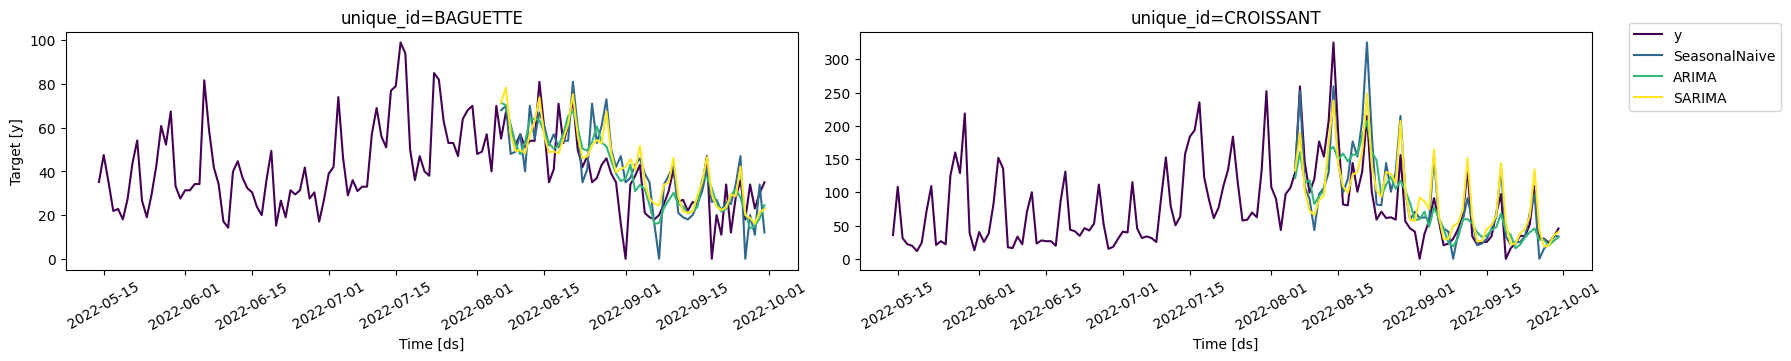

In [27]:
plot_series(
    df = small_data,
    forecasts_df = cv_df.drop(["y", "cutoff"], axis=1),
    ids = ["BAGUETTE", "CROISSANT"],
    max_insample_length = 140,
    palette = "viridis"
)

In [28]:
cv_eval = evaluate(
    cv_df.drop("cutoff", axis=1),
    metrics = [mae]
)

cv_eval = cv_eval.drop("unique_id", axis=1).groupby("metric").mean().reset_index()
cv_eval

,metric,SeasonalNaive,ARIMA,SARIMA
0,mae,21.117857,21.17093,19.281296


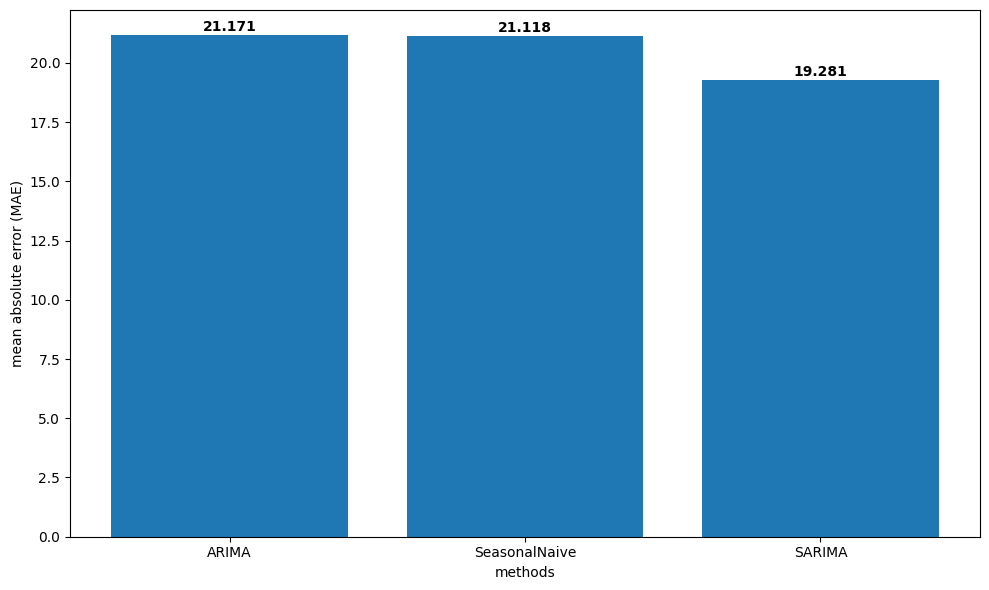

In [29]:
methods = cv_eval.columns[1:].tolist()
values = cv_eval.iloc[0, 1:].tolist()

sorted_data = sorted(
    zip(methods, values),
    key = lambda x: x[1],
    reverse = True
)
methods_sorted, values_sorted = zip(*sorted_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(methods_sorted, values_sorted)

for bar, value in zip(bars, values_sorted):
  plt.text(
      bar.get_x() + bar.get_width()/2,
      bar.get_height() + 0.05,
      f"{value:.3f}",
      ha = "center",
      va = "bottom",
      fontweight = "bold"
  )

plt.xlabel("methods")
plt.ylabel("mean absolute error (MAE)")
plt.tight_layout()
plt.show()

## forecasting with exogenous features

In [30]:
data = pd.read_csv("/content/daily_sales_french_bakery.csv", parse_dates=["ds"])
data = data.groupby("unique_id").filter(lambda x: len(x) >= 28)
data.head(10)

,unique_id,ds,y,unit_price
0,12 MACARON,2022-07-13,10.0,10.0
1,12 MACARON,2022-07-14,0.0,10.0
2,12 MACARON,2022-07-15,0.0,10.0
3,12 MACARON,2022-07-16,10.0,10.0
4,12 MACARON,2022-07-17,30.0,10.0
5,12 MACARON,2022-07-18,0.0,10.0
6,12 MACARON,2022-07-19,10.0,10.0
7,12 MACARON,2022-07-20,0.0,10.0
8,12 MACARON,2022-07-21,10.0,10.0
9,12 MACARON,2022-07-22,0.0,10.0


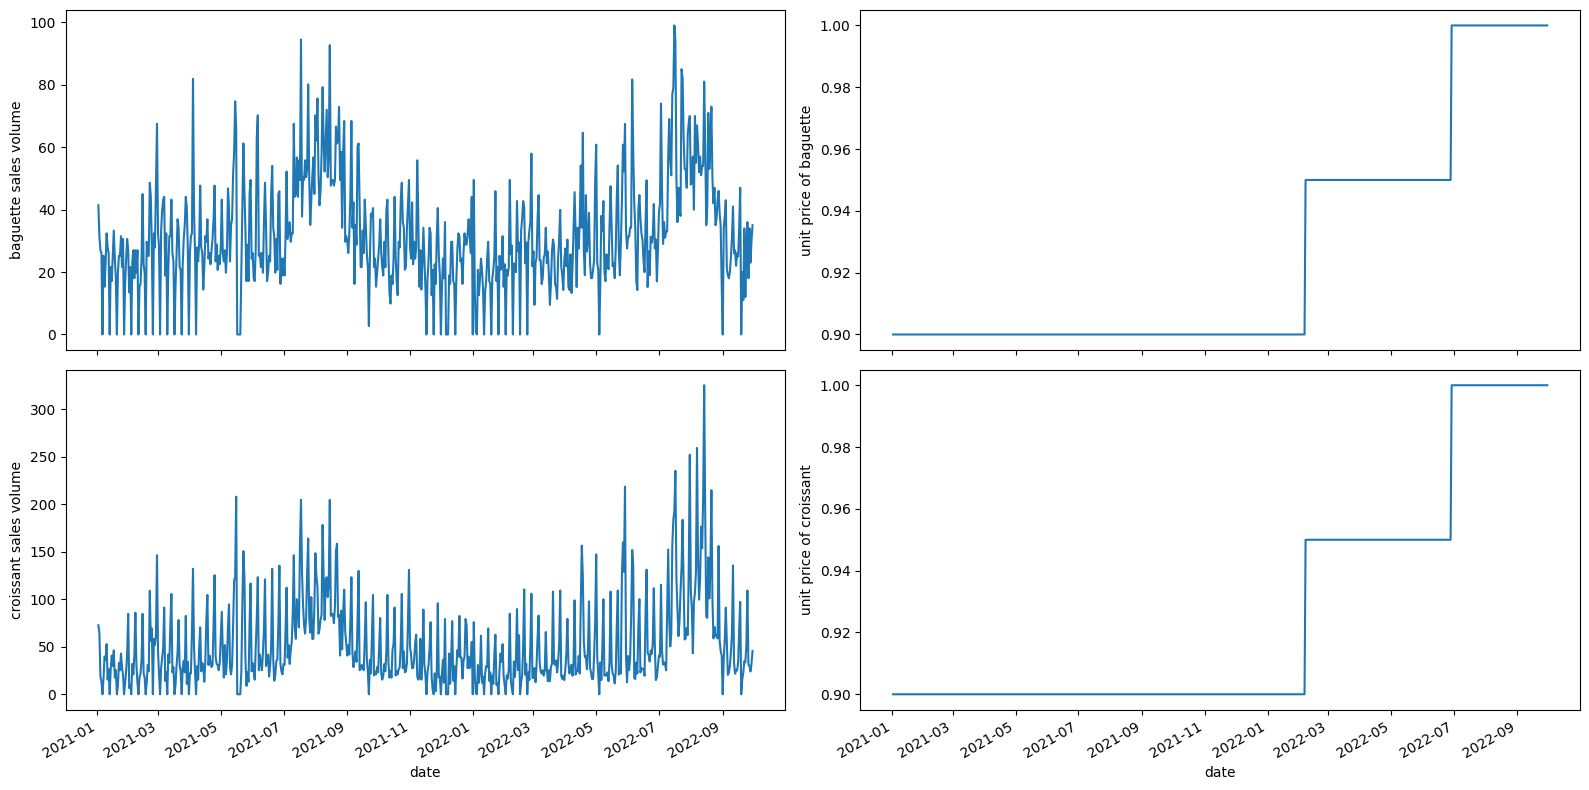

In [31]:
baguette_plot_df = data[data["unique_id"] == "BAGUETTE"]
croissant_plot_df = data[data["unique_id"] == "CROISSANT"]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))

ax1.plot(baguette_plot_df["ds"], baguette_plot_df["y"])
ax1.set_xlabel("date")
ax1.set_ylabel("baguette sales volume")

ax2.plot(baguette_plot_df["ds"], baguette_plot_df["unit_price"])
ax2.set_xlabel("date")
ax2.set_ylabel("unit price of baguette")

ax3.plot(baguette_plot_df["ds"], croissant_plot_df["y"])
ax3.set_xlabel("date")
ax3.set_ylabel("croissant sales volume")

ax4.plot(baguette_plot_df["ds"], baguette_plot_df["unit_price"])
ax4.set_xlabel("date")
ax4.set_ylabel("unit price of croissant")

fig.autofmt_xdate()
plt.tight_layout()

In [32]:
unique_ids = ["BAGUETTE", "CROISSANT"]
small_data = data[data["unique_id"].isin(unique_ids)]
test = small_data.groupby("unique_id").tail(7)
train = small_data.drop(test.index).reset_index(drop=True)

In [33]:
future_exog_df = test.drop("y", axis=1)
future_exog_df.head()

,unique_id,ds,unit_price
714,BAGUETTE,2022-09-24,1.0
715,BAGUETTE,2022-09-25,1.0
716,BAGUETTE,2022-09-26,1.0
717,BAGUETTE,2022-09-27,1.0
718,BAGUETTE,2022-09-28,1.0


In [34]:
# define model
models = [
    AutoARIMA(season_length=7, alias="SARIMA_exog")
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=train)

# prediction with exogenous features
arima_exog_preds = sf.predict(
    h = horizon,
    X_df = future_exog_df
)

# without exogenous features
models = [
    AutoARIMA(season_length=7, alias="SARIMA")
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=train.drop("unit_price", axis=1))
arima_preds = sf.predict(h=horizon)

In [35]:
test_df = test.merge(arima_exog_preds, on=["unique_id", "ds"], how="left")\
              .merge(arima_preds, on=["unique_id", "ds"], how="left")

test_df

,unique_id,ds,y,unit_price,SARIMA_exog,SARIMA
0,BAGUETTE,2022-09-24,28.0,1.0,28.898898,28.657114
1,BAGUETTE,2022-09-25,36.0,1.0,42.513264,42.182373
2,BAGUETTE,2022-09-26,18.0,1.0,20.423976,20.013652
3,BAGUETTE,2022-09-27,34.0,1.0,19.066264,18.646490
4,BAGUETTE,2022-09-28,23.0,1.0,16.468885,16.114925
5,BAGUETTE,2022-09-29,30.0,1.0,21.656726,21.288019
6,BAGUETTE,2022-09-30,35.0,1.0,23.101235,22.660124
7,CROISSANT,2022-09-24,51.6,1.2,64.424926,64.011002
8,CROISSANT,2022-09-25,109.2,1.2,135.124207,134.488202
9,CROISSANT,2022-09-26,31.2,1.2,43.526109,42.735407


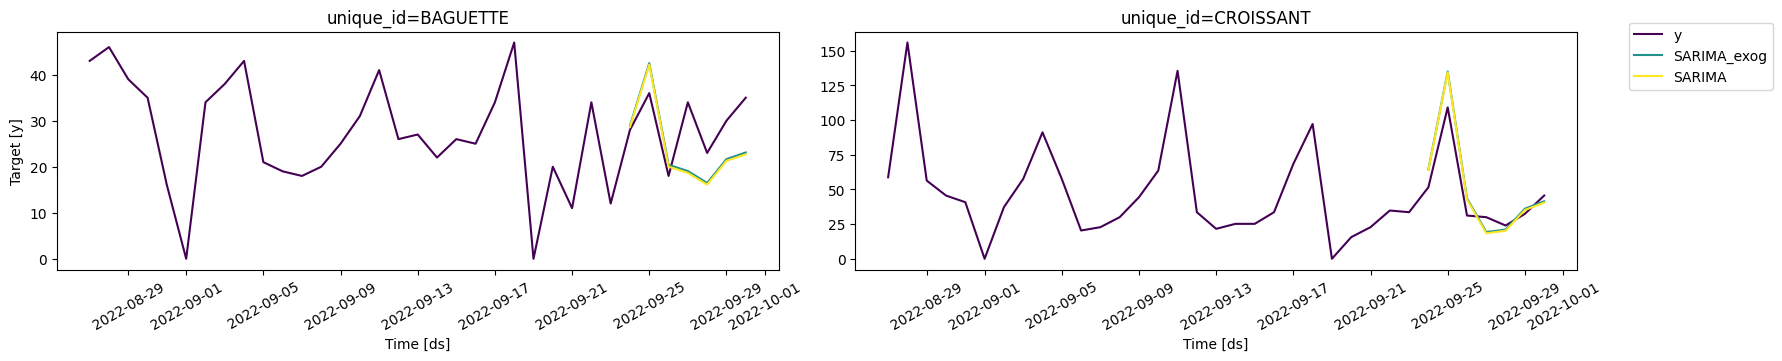

In [36]:
plot_series(
    df = train,
    forecasts_df = test_df,
    ids = ["BAGUETTE", "CROISSANT"],
    max_insample_length = 28,
    models = ["SARIMA_exog", "SARIMA"],
    palette = "viridis"
)

In [37]:
models = [
    AutoARIMA(season_length=7, alias="SARIMA_exog")
]
sf = StatsForecast(models=models, freq="D")

# running cross validation
cv_exog_df = sf.cross_validation(
    h = horizon,
    df = small_data,
    n_windows = 8,
    step_size = horizon,
    refit = True
)

cv_exog_df.head()

,unique_id,ds,cutoff,y,SARIMA_exog
0,BAGUETTE,2022-08-06,2022-08-05,55.0,71.511528
1,BAGUETTE,2022-08-07,2022-08-05,67.0,78.458054
2,BAGUETTE,2022-08-08,2022-08-05,61.0,57.062745
3,BAGUETTE,2022-08-09,2022-08-05,52.0,49.525901
4,BAGUETTE,2022-08-10,2022-08-05,57.0,49.485683


In [38]:
cv_exog_eval = evaluate(
    cv_exog_df.drop("cutoff", axis=1),
    metrics = [mae]
)
cv_exog_eval = cv_exog_eval.drop("unique_id", axis=1).groupby("metric").mean().reset_index()
cv_exog_eval

,metric,SARIMA_exog
0,mae,19.211687


## creating features from timestamps

In [39]:
from functools import partial
from utilsforecast.feature_engineering import fourier, time_features, pipeline

In [40]:
features = [
    partial(fourier, season_length=7, k=2),
    partial(time_features, features=["day", "week", "month"])
]

small_exog_df, future_exog_df = pipeline(
    df = small_data,
    features = features,
    freq = "D",
    h = horizon
)
small_exog_df.head()

,unique_id,ds,y,unit_price,sin1_7,sin2_7,cos1_7,cos2_7,day,week,month
84,BAGUETTE,2021-01-02,41.4,0.9,0.781832,0.974928,0.623490,-0.222521,2,53,1
85,BAGUETTE,2021-01-03,31.5,0.9,0.974928,-0.433884,-0.222521,-0.900969,3,53,1
86,BAGUETTE,2021-01-04,27.0,0.9,0.433884,-0.781831,-0.900969,0.623490,4,1,1
87,BAGUETTE,2021-01-05,26.1,0.9,-0.433884,0.781832,-0.900969,0.623490,5,1,1
88,BAGUETTE,2021-01-06,0.0,0.9,-0.974928,0.433884,-0.222521,-0.900969,6,1,1


In [41]:
future_exog_df.head()

,unique_id,ds,sin1_7,sin2_7,cos1_7,cos2_7,day,week,month
0,BAGUETTE,2022-10-01,0.781844,0.974919,0.623474,-0.222559,1,39,10
1,BAGUETTE,2022-10-02,0.974927,-0.433892,-0.222526,-0.900965,2,39,10
2,BAGUETTE,2022-10-03,0.433893,-0.781844,-0.900964,0.623474,3,40,10
3,BAGUETTE,2022-10-04,-0.433861,0.781800,-0.900980,0.623529,4,40,10
4,BAGUETTE,2022-10-05,-0.974933,0.433846,-0.222500,-0.900987,5,40,10


In [42]:
models = [
    AutoARIMA(season_length=7, alias="SARIMA_time_exog")
]

sf = StatsForecast(models=models, freq="D")
cv_time_exog_df = sf.cross_validation(
    h = horizon,
    df = small_exog_df,
    n_windows = 8,
    step_size = horizon,
    refit = True
)

cv_time_exog_eval = evaluate(
    cv_time_exog_df.drop("cutoff", axis=1),
    metrics = [mae]
)

cv_time_exog_eval = cv_time_exog_eval.drop("unique_id", axis=1).groupby("metric").mean().reset_index()
cv_time_exog_eval

,metric,SARIMA_time_exog
0,mae,19.721581


## prediction intervals

In [43]:
unique_ids = ["BAGUETTE", "CROISSANT"]
small_data = data[data["unique_id"].isin(unique_ids)]
test = small_data.groupby("unique_id").tail(7)
train = small_data.drop(test.index).reset_index(drop=True)

In [45]:
train.head()

,unique_id,ds,y,unit_price
0,BAGUETTE,2021-01-02,41.4,0.9
1,BAGUETTE,2021-01-03,31.5,0.9
2,BAGUETTE,2021-01-04,27.0,0.9
3,BAGUETTE,2021-01-05,26.1,0.9
4,BAGUETTE,2021-01-06,0.0,0.9


In [46]:
models = [
    AutoARIMA(season_length=7)
]

sf = StatsForecast(models=models, freq="D")
sf.fit(df=train)
prob_preds = sf.predict(
    h = horizon,
    X_df = test.drop("y", axis=1),
    level = [80]
)

In [47]:
test_df = test.merge(prob_preds, on=["unique_id", "ds"], how="left")

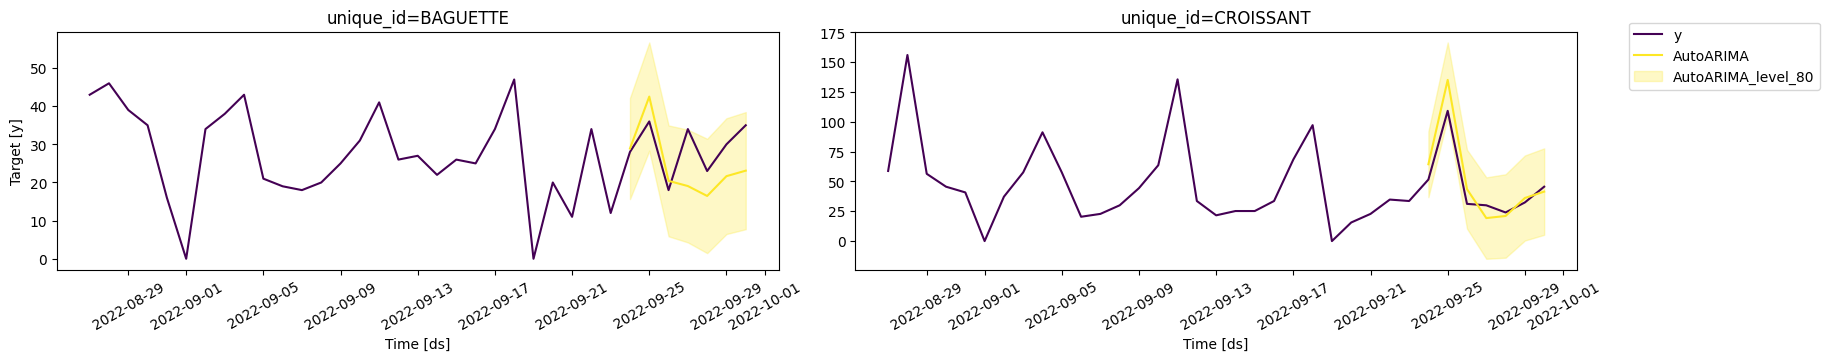

In [50]:
plot_series(
    df = train,
    forecasts_df = test_df,
    ids = ["BAGUETTE", "CROISSANT"],
    max_insample_length = 28,
    models = ["AutoARIMA"],
    level = [80],
    palette = "viridis"
)

In [51]:
# running cross validation
models = [
    AutoARIMA(season_length=7)
]

sf = StatsForecast(models=models, freq="D")

cv_prob_df = sf.cross_validation(
    h = horizon,
    df = small_data,
    n_windows = 8,
    step_size = horizon,
    refit = True,
    level = [80]
)

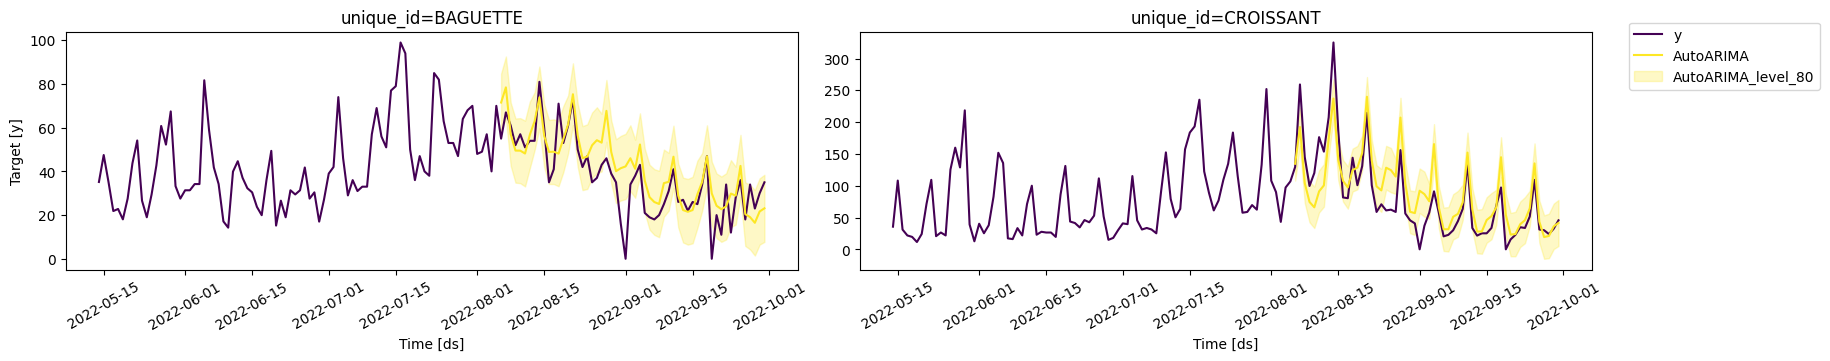

In [53]:
plot_series(
    df = small_data,
    forecasts_df = cv_prob_df.drop(["y", "cutoff"], axis=1),
    ids = ["BAGUETTE", "CROISSANT"],
    models = ["AutoARIMA"],
    max_insample_length = 140,
    level = [80],
    palette = "viridis"
)

## evaluation metrics

In [55]:
models = [
    AutoARIMA(season_length=7, alias="SARIMA_exog"),
    SeasonalNaive(season_length=7)
]

sf = StatsForecast(models=models, freq="D")

final_cv_df = sf.cross_validation(
    h = horizon,
    df = small_data,
    n_windows = 8,
    step_size = 7,
    refit = True,
    level = [80]
)
final_cv_df.head()

,unique_id,ds,cutoff,y,SARIMA_exog,SARIMA_exog-lo-80,SARIMA_exog-hi-80,SeasonalNaive,SeasonalNaive-lo-80,SeasonalNaive-hi-80
0,BAGUETTE,2022-08-06,2022-08-05,55.0,71.511528,58.279213,84.743843,68.0,50.158042,85.841958
1,BAGUETTE,2022-08-07,2022-08-05,67.0,78.458054,64.354114,92.561995,70.0,52.158042,87.841958
2,BAGUETTE,2022-08-08,2022-08-05,61.0,57.062745,42.622201,71.503290,48.0,30.158042,65.841958
3,BAGUETTE,2022-08-09,2022-08-05,52.0,49.525901,34.847356,64.204446,49.0,31.158042,66.841958
4,BAGUETTE,2022-08-10,2022-08-05,57.0,49.485683,34.606853,64.364512,57.0,39.158042,74.841958


In [57]:
temp_test = small_data.groupby("unique_id").tail(7*8)
temp_train = small_data.drop(test.index).reset_index(drop=True)

In [58]:
models = ["SARIMA_exog", "SeasonalNaive"]
metrics = [
    mae,
    mse,
    rmse,
    mape,
    smape,
    partial(mase, seasonality=7),
    scaled_crps
]

final_eval = evaluate(
    final_cv_df.drop(["ds", "cutoff"], axis=1),
    metrics = metrics,
    models = models,
    train_df = temp_train,
    level = [80]
)

final_eval = final_eval.drop("unique_id", axis=1).groupby("metric").mean().reset_index()
final_eval

,metric,SARIMA_exog,SeasonalNaive
0,mae,19.211687,21.117857
1,mape,0.328615,0.376819
2,mase,1.140788,1.285069
3,mse,792.788111,970.417143
4,rmse,24.979598,27.875413
5,scaled_crps,0.153636,0.166451
6,smape,0.168241,0.211317


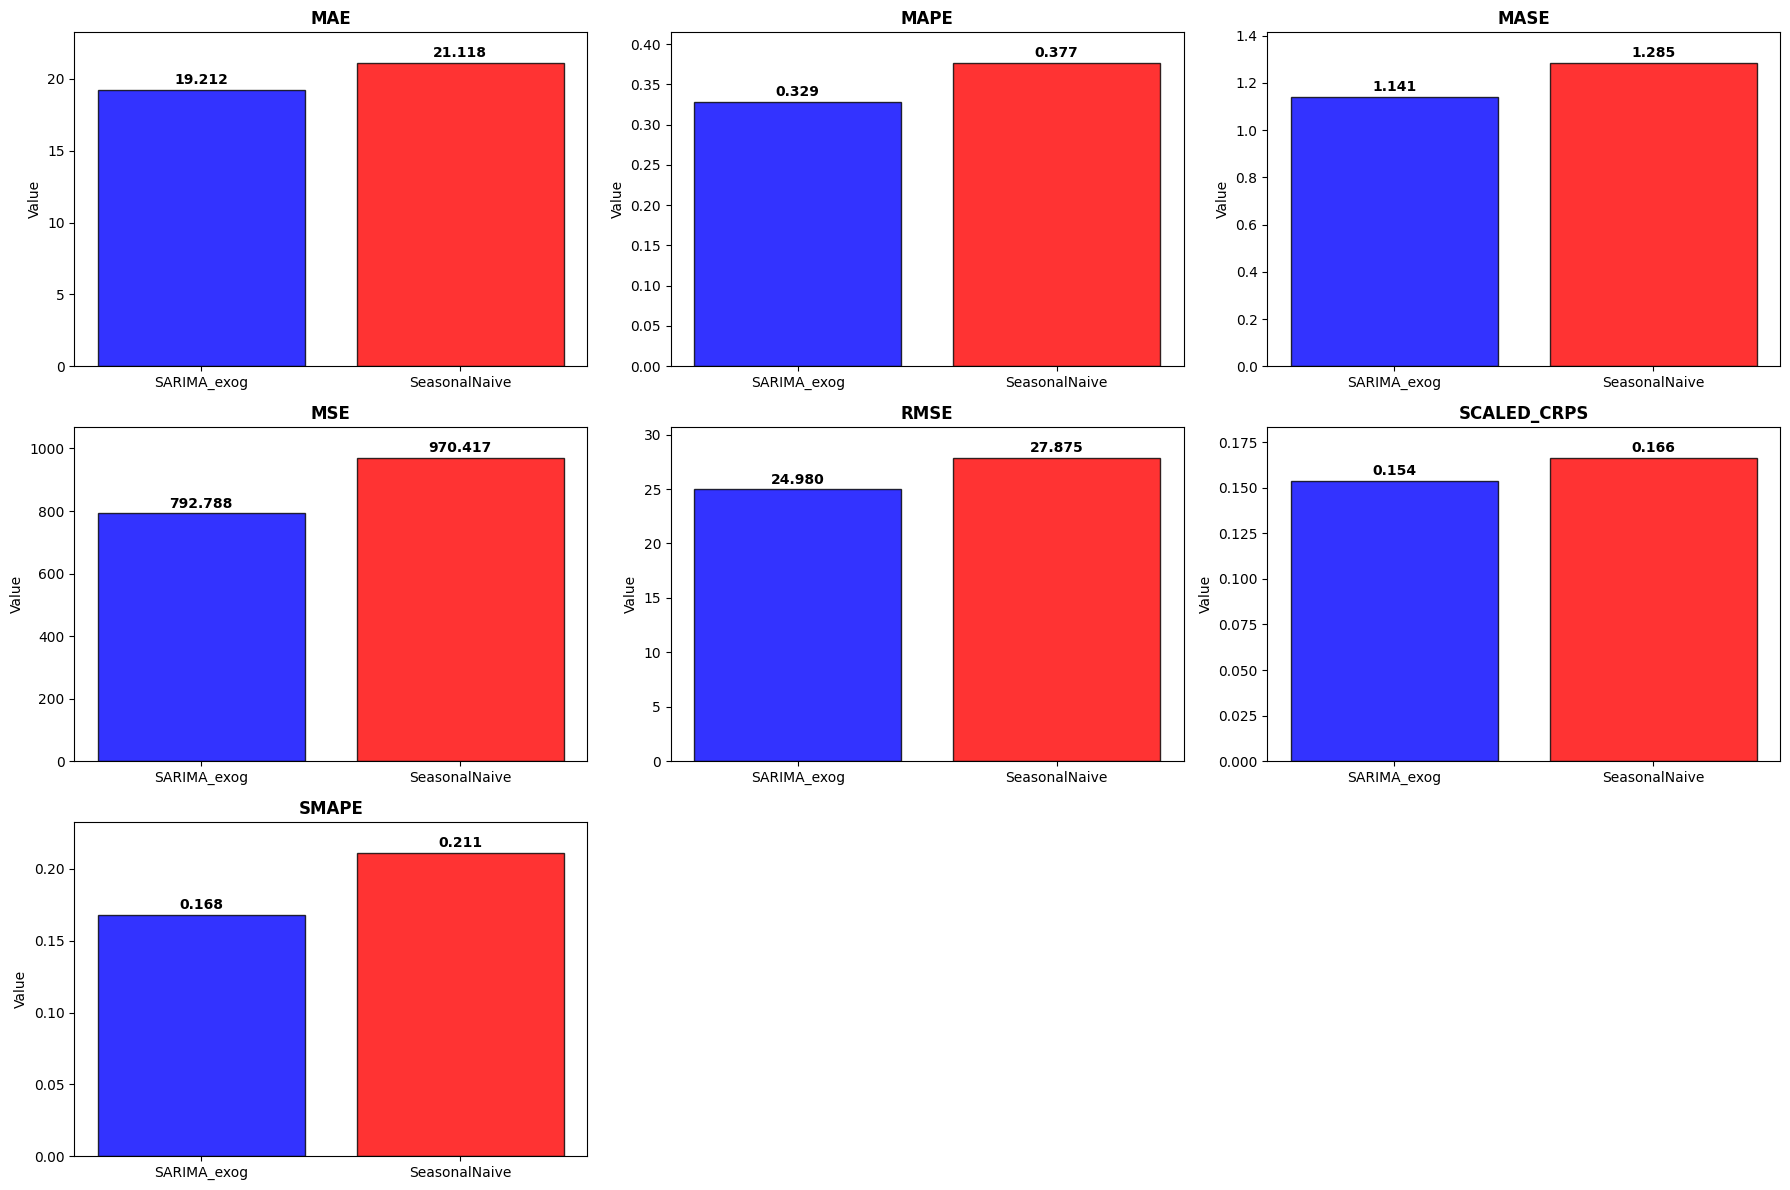

In [59]:


fig, axes = plt.subplots(3, 3, figsize=(18, 12))

axes_flat = axes.flatten()

models = ['SARIMA_exog', 'SeasonalNaive']
x_pos = [0, 1]
colors = ['blue', 'red']

for i, row in final_eval.iterrows():
    ax = axes_flat[i]

    model_values = [row['SARIMA_exog'], row['SeasonalNaive']]

    bars = ax.bar(x_pos, model_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1)

    for j, (bar, value) in enumerate(zip(bars, model_values)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{value:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

    ax.set_title(row['metric'].upper(), fontweight='bold', fontsize=12)
    ax.set_xticks(x_pos)
    ax.set_xticklabels(models, ha='center')
    ax.set_ylabel('Value')
    max_value = max(model_values)
    ax.set_ylim(0, max_value * 1.1)

fig.delaxes(axes_flat[7])

axes_flat[8].set_visible(False)

plt.tight_layout()
plt.show()

## lesson 1 wrapped